In [1]:
!pip -q install simpy scikit-learn pandas numpy matplotlib


In [2]:
import simpy
import random
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt


In [3]:
def mm1_simulation(arrival_rate, service_rate, sim_time=1000, seed=0):
    random.seed(seed)
    np.random.seed(seed)

    env = simpy.Environment()
    server = simpy.Resource(env, capacity=1)

    wait_times = []
    system_times = []
    queue_lengths = []
    busy_time = 0.0

    def customer(env, name):
        nonlocal busy_time
        arrival_time = env.now

        with server.request() as req:
            yield req
            service_start = env.now
            wait_times.append(service_start - arrival_time)

            service_time = random.expovariate(service_rate)
            busy_time += service_time
            yield env.timeout(service_time)

            departure_time = env.now
            system_times.append(departure_time - arrival_time)

    def arrival_process(env):
        i = 0
        while True:
            queue_lengths.append(len(server.queue))
            interarrival = random.expovariate(arrival_rate)
            yield env.timeout(interarrival)
            i += 1
            env.process(customer(env, f"C{i}"))

    env.process(arrival_process(env))
    env.run(until=sim_time)

    avg_wait = float(np.mean(wait_times)) if wait_times else 0.0
    avg_system = float(np.mean(system_times)) if system_times else 0.0
    avg_queue = float(np.mean(queue_lengths)) if queue_lengths else 0.0
    utilization = float(busy_time / sim_time)

    return avg_wait, avg_system, avg_queue, utilization


In [4]:
def random_params():
    arrival_rate = np.random.uniform(0.2, 2.0)
    service_rate = np.random.uniform(max(arrival_rate + 0.1, 0.5), 3.0)
    sim_time = int(np.random.uniform(200, 2000))
    return arrival_rate, service_rate, sim_time

rows = []
for i in range(1000):
    lam, mu, T = random_params()
    avg_wait, avg_system, avg_queue, util = mm1_simulation(lam, mu, sim_time=T, seed=i)
    rows.append([lam, mu, T, avg_wait, avg_system, avg_queue, util])

df = pd.DataFrame(rows, columns=[
    "arrival_rate", "service_rate", "sim_time",
    "avg_wait", "avg_system_time", "avg_queue_length", "utilization"
])
df.head()


,arrival_rate,service_rate,sim_time,avg_wait,avg_system_time,avg_queue_length,utilization
0,0.892052,2.531764,1662,0.244328,0.657365,0.210000,0.372528
1,1.187864,2.512366,1284,0.364271,0.773085,0.429591,0.490321
2,0.950640,2.454812,200,0.183102,0.583144,0.156069,0.344036
3,0.984791,1.134445,1189,3.473424,4.344185,3.334462,0.864170
4,1.191436,2.501352,723,0.443531,0.868715,0.545984,0.504656


In [5]:
df.to_csv("simpy_mm1_dataset.csv", index=False)
print("Saved simpy_mm1_dataset.csv")


Saved simpy_mm1_dataset.csv


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

X = df[["arrival_rate", "service_rate", "sim_time"]]
y = df["avg_wait"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [7]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "KNN": KNeighborsRegressor(),
    "SVR": SVR(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "ExtraTrees": ExtraTreesRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
}


In [8]:
results = []

for name, model in models.items():
    t0 = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - t0

    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)

    results.append([name, r2, mae, rmse, train_time])

res_df = pd.DataFrame(results, columns=["Model", "R2", "MAE", "RMSE", "TrainTime_sec"])
res_df = res_df.sort_values("R2", ascending=False)
res_df


,Model,R2,MAE,RMSE,TrainTime_sec
5,RandomForest,0.721525,0.239578,0.543387,0.409646
7,GradientBoosting,0.704415,0.283595,0.559831,0.218434
6,ExtraTrees,0.702098,0.230121,0.562021,0.217034
1,Ridge,0.494293,0.535391,0.732260,0.009604
0,LinearRegression,0.493259,0.537224,0.733009,0.028425
2,Lasso,-0.012242,0.758355,1.035997,0.002343
4,SVR,-0.130658,0.643512,1.094919,0.030104
3,KNN,-0.479468,0.865313,1.252475,0.002930


In [9]:
best = res_df.iloc[0]
print("Best Model:", best["Model"])


Best Model: RandomForest


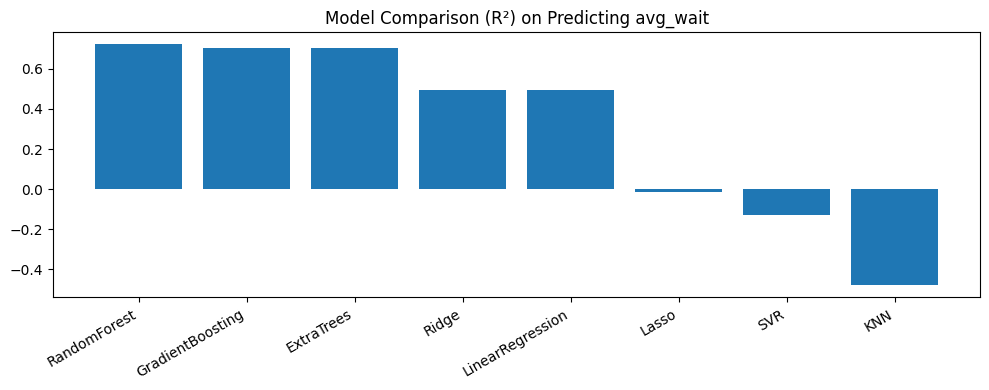

In [10]:
plt.figure(figsize=(10,4))
plt.bar(res_df["Model"], res_df["R2"])
plt.xticks(rotation=30, ha="right")
plt.title("Model Comparison (R²) on Predicting avg_wait")
plt.tight_layout()
plt.savefig("model_comparison_r2.png", dpi=200)
plt.show()


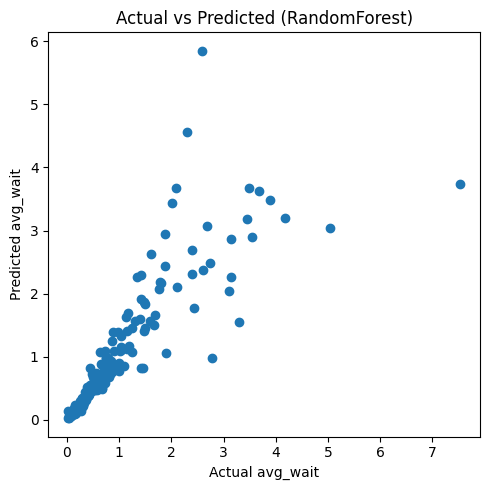

In [11]:
best_model_name = res_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)
preds = best_model.predict(X_test)

plt.figure(figsize=(5,5))
plt.scatter(y_test, preds)
plt.xlabel("Actual avg_wait")
plt.ylabel("Predicted avg_wait")
plt.title(f"Actual vs Predicted ({best_model_name})")
plt.tight_layout()
plt.savefig("actual_vs_predicted.png", dpi=200)
plt.show()
